In [5]:
import logging
import os
import requests
import random

logger = logging.getLogger(__name__)
logger.setLevel(logging.WARNING)

get_weather_schema = {
    "name": "get_weather_api",
    "parameters": {
        "type": "object",
        "properties": {
            "location": {
                "type": "string",
                "description": (
                    "输入想要查询天气的所在地，例如，北京"
                ),
            },
            "date": {
                "type": "string",
                "description": (
                    "输入想要查询天气的日期，例如，2023-11-01"
                ),
            }
        },
        "required": [
            "location"
        ]
    },
  "description": "这是一个能够查询指定地点和日期天气状况的API接口，日期参数不传默认为当天"
}

def get_weather(location, date):
    print("get_weather called:", location, date)
    temperature = random.randint(0,10)
    return "\n\n" + "天气晴，" + str(temperature) + "摄氏度"

In [6]:
from autogen import config_list_from_json
from autogen.agentchat.contrib.gpt_assistant_agent import GPTAssistantAgent
from autogen import UserProxyAgent
import autogen

assistant_id = os.environ.get("ASSISTANT_ID", None)
config_list = config_list_from_json("../OAI_CONFIG_LIST")
llm_config = {
    "config_list": config_list
}

weather_man = GPTAssistantAgent(
    name="Weather_reporter",                            
    instructions=(
        "一个天气报告员，可以通过工具来查询指定地点和日期的天气情况。"
    ),
    llm_config={
        "config_list": config_list,
        "assistant_id": assistant_id,
        "tools": [
            {
                "type": "function",
                "function": get_weather_schema,
            }
        ]
    },
)
weather_man.register_function(
    function_map={
        "get_weather_api": get_weather
    }
)

vis_assistant = GPTAssistantAgent(
    name="Visualization_Assistant",
    llm_config={
        "tools": [
            {
                "type": "code_interpreter"
            }
        ],
        "config_list": config_list,
    },
    instructions="图表可视化专家，擅长通过写python代码，将数据以可视化图表的方式呈现出来。回复中包含\"TERMINATE\"字符串，当可视化任务处理结束时。",
)

user_proxy = autogen.UserProxyAgent(
   name="User_proxy",
   system_message="A human admin.",
   code_execution_config={"last_n_messages": 2, "work_dir": "groupchat"},
   human_input_mode="TERMINATE",
   is_termination_msg=lambda msg: "TERMINATE" in msg["content"]
)

GPT Assistant only supports one OpenAI client. Using the first client in the list.
assistant_id was None, creating a new assistant


GPT Assistant only supports one OpenAI client. Using the first client in the list.
assistant_id was None, creating a new assistant


In [17]:
import autogen
groupchat = autogen.GroupChat(agents=[user_proxy, vis_assistant, weather_man], messages=[], max_round=12)
manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=llm_config)

user_proxy.initiate_chat(manager, message="今天是2023-11-20，根据北京最近5天的天气趋势，预测下明天的天气")
#user_proxy.initiate_chat(manager, message="今天是2023-11-20，分析北京最近5天的天气趋势，以折线图的方式呈现")

User_proxy (to chat_manager):

今天是2023-11-20，根据北京最近5天的天气趋势，预测下明天的天气

--------------------------------------------------------------------------------


Select next speaker:  Weather_reporter
Assistants thread run:  Run(id='run_9qNk79j4oeDj2r4ut0EXZVle', assistant_id='asst_Wc4Nnmyn2VgnarnHXpb7vPm9', cancelled_at=None, completed_at=None, created_at=1700479426, expires_at=1700480026, failed_at=None, file_ids=[], instructions='一个天气报告员，可以通过工具来查询指定地点和日期的天气情况。', last_error=None, metadata={}, model='gpt-4-1106-preview', object='thread.run', required_action=RequiredAction(submit_tool_outputs=RequiredActionSubmitToolOutputs(tool_calls=[RequiredActionFunctionToolCall(id='call_yjOJKQu6BDtL7fJpEBbYG094', function=Function(arguments='{"location": "北京", "date": "2023-11-15"}', name='get_weather_api'), type='function'), RequiredActionFunctionToolCall(id='call_6Boj6xEoZLel8AwfLeezHQv5', function=Function(arguments='{"location": "北京", "date": "2023-11-16"}', name='get_weather_api'), type='function'), RequiredActionFunctionToolCall(id='call_roNf2ZvSm5R7f8MrPTkFwMk9', function=Function(arguments='{"location": "北京", "date": "2023-11-17"}', name='get_weath

File downloaded successfully.


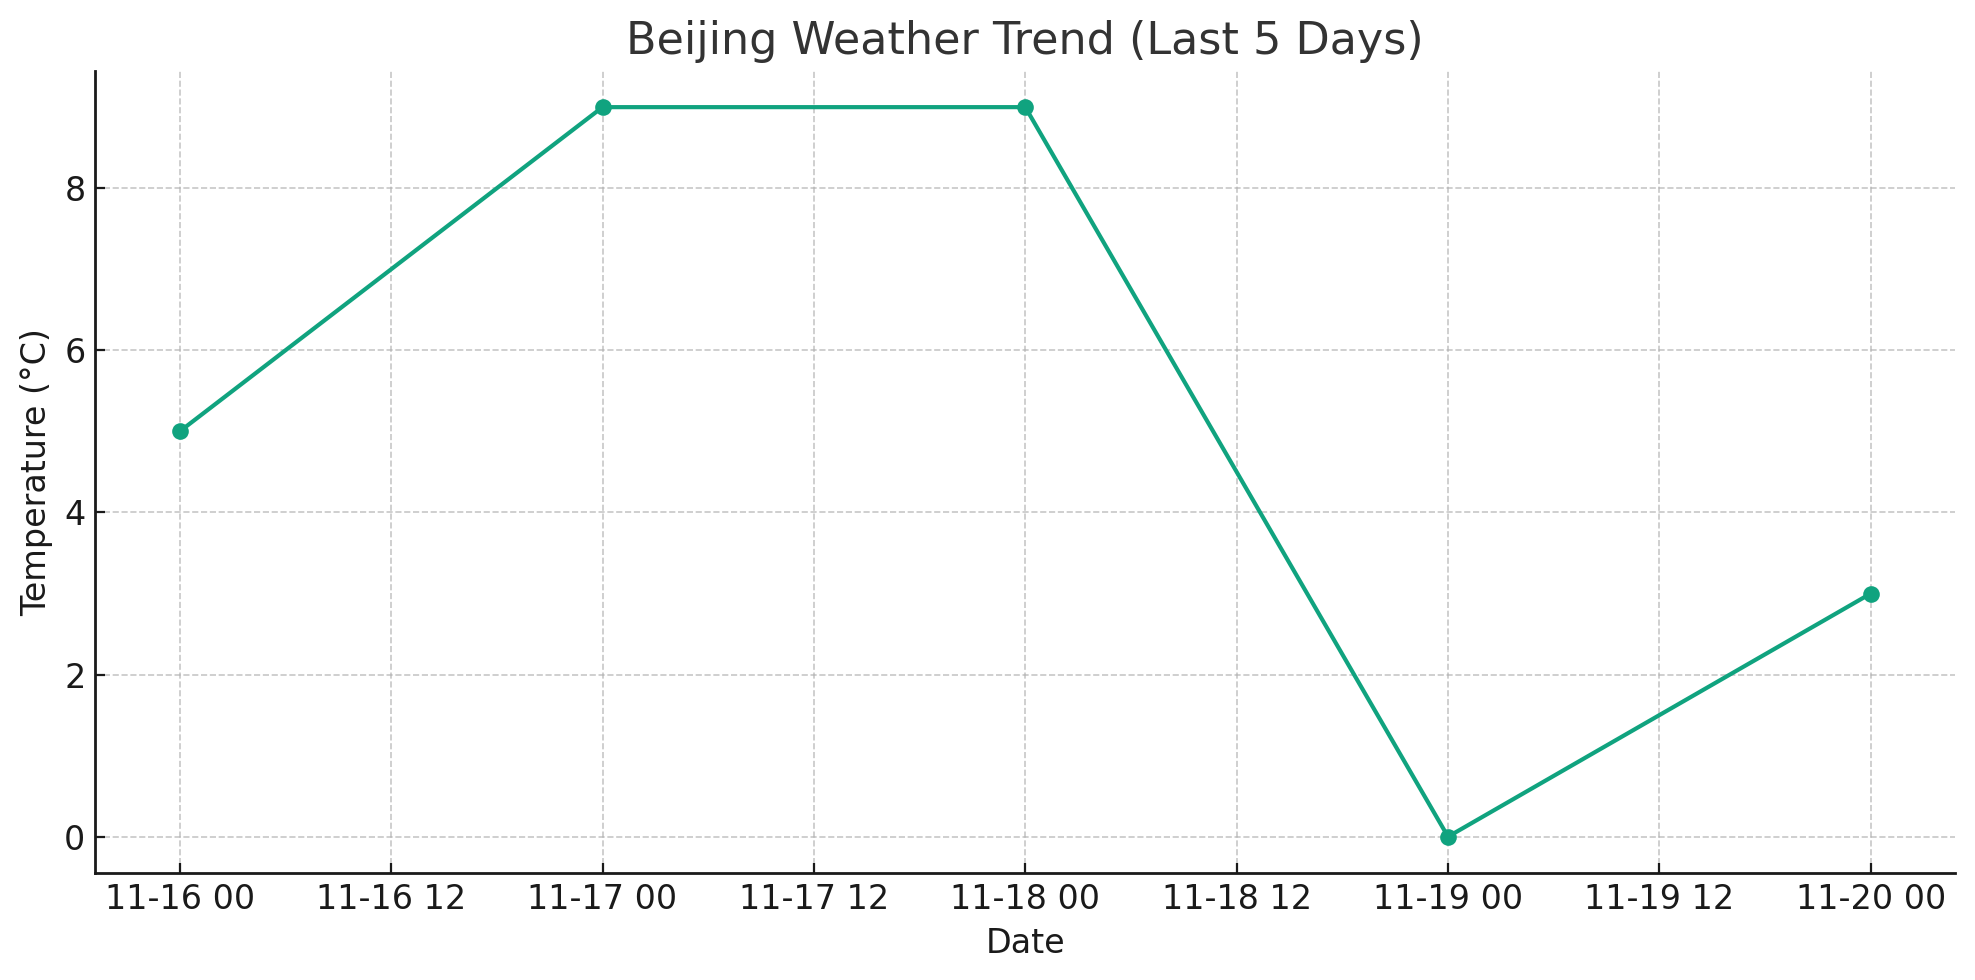

In [16]:
from IPython.display import Image

pic_list = []
for message in groupchat.messages:
    if 'Visualization_Assistant' == message['name']:
        content = message['content']
        for line in content.split('\n'):
            if 'Recieved file id=' in line:
                pic_list.append(line.replace('Recieved file id=', ''))


for pic in pic_list:
    api_response = vis_assistant.openai_client.files.with_raw_response.retrieve_content(pic)

    if api_response.status_code == 200:
        content = api_response.content
        with open('image.png', 'wb') as f:
            f.write(content)
            print('File downloaded successfully.')
Image(filename='image.png')  